In [50]:
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup as soup
import re
import string
import pandas as pd
import nltk
from matplotlib import pyplot as plt
%matplotlib inline

<strong>Raw data collection and processing</strong>

In [36]:
# initiating list that all jobs will be posted to
full_job_list = []

def get_page(page_number):
        
    url = "https://careersuccess.nbmbaa.org/jobs/?"

    get_params= {
        "keywords":"",
        "sort":"",
        "event_id":"4070",
        "page":page_number
    }
    
    r = requests.get(url, params=get_params)
    
    # setting up post params for number of entries per page
    post_params = {
        "bti-pagination-rpp":"25"
    }
    
    r_post = requests.post(r.url, data=post_params)
    
    # parsing the data after post
    page_soup = soup(r_post.text, "html.parser")
    
    # list of jobs
    job_soup = page_soup.find_all("div", {"class":"bti-ui-job-detail-container"})
    
    for job in job_soup:
        job_title = job.find("a", {"class":"bti-job-detail-link"}).text.strip()
        employer = job.find("div", {"class":"bti-ui-job-result-detail-employer"}).text.strip()
        location = job.find("div", {"class":"bti-ui-job-result-detail-location"}).text.strip()
        posted = job.find("div", {"class":"bti-ui-job-result-detail-age"}).text.strip()
        
        # concatenating tail end of link
        head_link = "https://careersuccess.nbmbaa.org"
        tail_link = job.find("a", {"class":"bti-job-detail-link"})['href'].strip()
        full_link = head_link + tail_link
        
        temp_list = [job_title, employer, location, posted, full_link]
        
        # adding each job to a list
        full_job_list.append(temp_list)

In [37]:
def final_pages(number):
    for i in range(number):
        get_page(i+1)

# input the current total number of pages on the job postings site
final_pages(16)

In [6]:
df = pd.DataFrame(columns=["Job Title", "Employer", "Location", "Posted", "Link"])

for i in range(len(full_job_list)):
    df.loc[i] = full_job_list[i]

df.head()

,Job Title,Employer,Location,Posted,Link
0,Summer Executive Associate - Leadership Develo...,M&T; Bank / Wilmington Trust,"Buffalo, New York",Yesterday,https://careersuccess.nbmbaa.org/jobs/12798276...
1,Hubbell Summer 2020 Internships,Hubbell Incorporated,"Nationwide, United States",Yesterday,https://careersuccess.nbmbaa.org/jobs/12827113...
2,MBA - Career Development Program (NBMBAA),USAA,"San Antonio, Texas",Yesterday,https://careersuccess.nbmbaa.org/jobs/12827034...
3,MBA Marketing - Associate Brand Manager (2nd Y...,E. & J. Gallo Winery,"Modesto, California",Yesterday,https://careersuccess.nbmbaa.org/jobs/12827497...
4,Opportunities with Global Private Banking,HSBC,"New York, New York",2 Days Ago,https://careersuccess.nbmbaa.org/jobs/12822783...


In [79]:
df.to_excel(r'/Users/andrewli/Desktop/NBMBAA 2019 Conference Job Postings.xlsx')

<strong>Job Description Exploration and Analysis</strong>

In [40]:
# Conditional Frequency Distribution (based on job category)
cfd = nltk.ConditionalFreqDist()

for entry in full_job_list:
    # reading and parsing html page
    url = urlopen(str(entry[4]))

    page_html = url.read()
    url.close()
    page_soup = soup(page_html, "html.parser")

    # find job categories on html text
    # job details container
    job_details_soup = page_soup.find("div", {"class":"bti-jd-details-other"})
    
    try:
        # job detail div
        job_tags = job_details_soup.find_all("div")

        # extracting job categories
        idx = 0
        while idx < len(job_tags):
            if job_tags[idx].text.startswith("Categor"):
                category_soup = job_tags[idx]
                job_cat_soup = job_tags[idx+1]
                break
            idx += 1

        job_category = job_cat_soup.text.split(",")

        # only going to consider jobs that have 1 category
        if len(job_category) == 1:
            # cleaning / normalizing
            category = job_category[0].lower().strip()

            # establishing parameters for cleaning text
            stopwords = nltk.corpus.stopwords.words('english')

            # read/clean text of job description
            raw_description = page_soup.find("div", {"class":"bti-jd-description"}).find("td").text
            tokens = nltk.word_tokenize(raw_description)
            no_stopwords = [word.lower() for word in tokens if word not in stopwords]
            no_punctuation = [word for word in no_stopwords if word not in string.punctuation]
            final_clean = [word for word in no_punctuation if len(word) > 2]

            # freq dist of words
            fd = nltk.FreqDist(final_clean)

            for (word, _) in fd.most_common(10):
                cfd[category][word] += 1
    
    except AttributeError:
        pass


In [41]:
# Isolated categories for each FreqDist in the ConditionalFreqDist
cfd.conditions()

['business management & administration',
 'sales/new business development',
 'finance/accounting',
 'marketing',
 'human services',
 'education & training',
 'health science',
 'information technology',
 'manufacturing',
 'consultancy']

<strong>Visualization</strong>

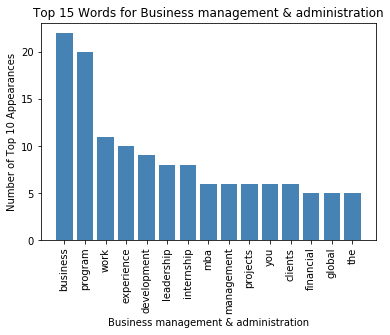

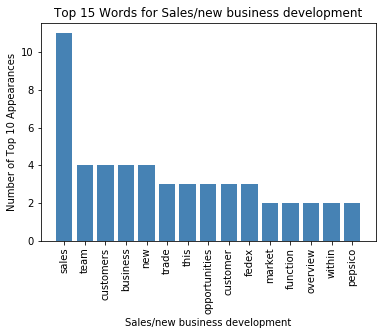

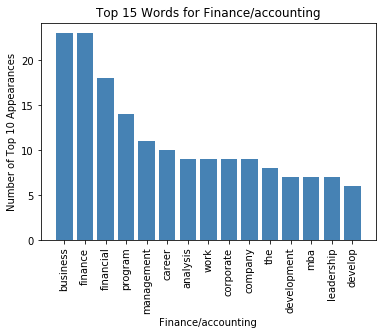

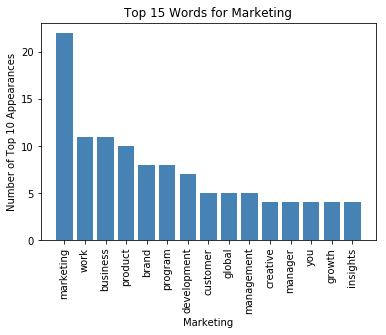

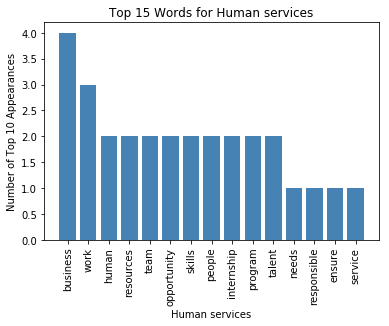

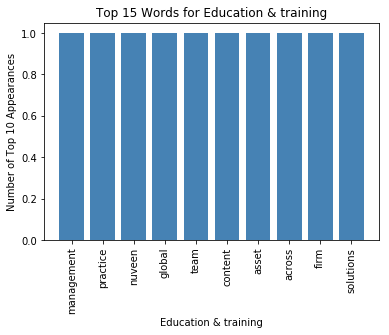

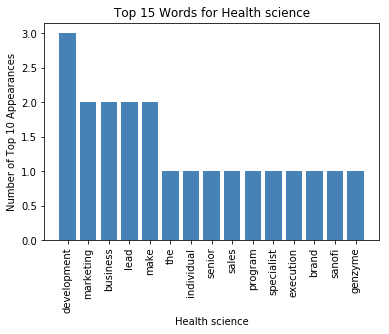

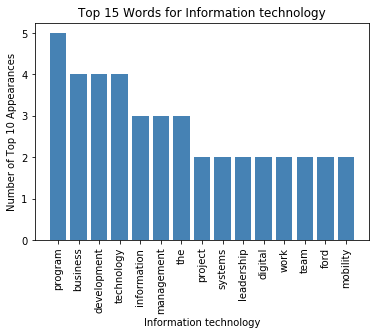

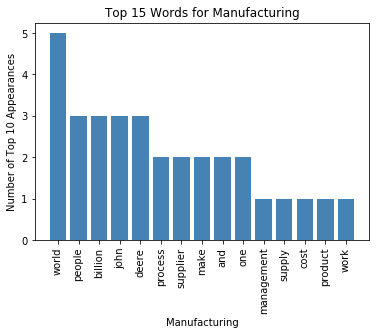

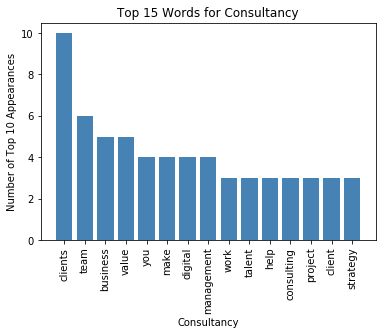

In [78]:
# Plotting the most common words for job postings for each category

for condition in cfd.conditions():
    x = []
    y = []
    for (category,value) in cfd[condition].most_common(15):
        x.append(category)
        y.append(value)

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, y, color='steelblue')
    plt.xticks(x_pos, x, rotation='vertical')
    plt.title("Top 15 Words for {}".format(condition.capitalize()))
    plt.xlabel(condition.capitalize())
    plt.ylabel("Number of Top 10 Appearances")
    plt.show()


<strong>Interpretation</strong>

After analyzing and visualizing the data to see the top 15 keywords for each category, below are the keywords, taken from the job postings data that was extracted, that would be great to include on resumes/cover letters for the job category that the candidate is applying to:

Note: excluded "Education & Training" and "Health Science" due to sparse data from these two categories.

Business Management & Administration:
- business
- program
- development
- leadership
- management
- projects
- clients
- financial
- global

Sales/New Business Development
- sales
- team
- customer(s)
- trade
- opportunities
- market

Finance/Accounting:
- financial
- management
- analysis
- corporate
- develop/development
- leadership

Marketing:
- marketing
- product
- brand
- program
- customer
- global
- creative
- growth
- insights

Human Services:
- human
- resources
- team
- opportunity
- people
- talent
- needs
- ensure

Information Technology
- program (programming skills)
- development
- technology
- information
- management
- project
- systems
- digital

Manufacturing:
- world (global)
- people
- john deere
- process
- supplier
- make
- supply
- cost
- product

Consulting:
- client(s) (not surprising #1 most common word here)
- team
- value
- digital
- management
- project
- strategy